In [29]:
!pip install pandas
!pip install numpy
!pip install nltk
!pip install tensorflow
!pip install scikit-learn
!pip install keras

In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shilp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, to_categorical
from keras.models import Sequential, Model
from keras.layers import *

# To ignore any warnings while running code 
import warnings
warnings.filterwarnings('ignore')

In [32]:
def load_labelled_data():
    print("Loading data from CSV file")
    data = pd.read_csv("../data/data.csv", header=None)
    data = data.sample(frac=0.5, random_state=42)

    print("Data loading complete")
    return data

In [33]:
# Graph of Data Distribution
CountPlot = 0
HeatMap = 1

def plotGraph(data, title, x_label='', y_label='', graph=CountPlot):
    fig, ax = plt.subplots(figsize=(6,5))
    if(graph==CountPlot) :
        sns.countplot(x = x_label ,data = data,)

    elif(graph==HeatMap) :
        sns.heatmap(data = data, cmap='Blues', annot=True, fmt='')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
    else:
        return
    
    plt.title(title)
    plt.show()

In [34]:
def under_sampling(data):
    print("Initiating undersampling of data")

    fakeReview = data[data['label']==0]
    authenticReview = data[data['label']==1]

    fakeReviewSize = len(fakeReview)
    authenticReviewSize = len(authenticReview)
    print(" Real review count:", len(authenticReview) )
    print(" Fake review count:", fakeReviewSize)

    if(fakeReviewSize < authenticReviewSize):

        authReview_Us_Data = authenticReview.sample(fakeReviewSize)
        us_Data = pd.concat([authReview_Us_Data, fakeReview], axis=0)

        f_us_data = us_Data[us_Data['label']==0]
        r_us_data = us_Data[us_Data['label']==1]
        print("Under Sampled Fake review count:", len(f_us_data))
        print("Under Sampled Real review count:", len(r_us_data))

        print("Under Sampling Completed ")
    else:
        print("Require no under sampling ")
        us_Data = data
    return us_Data


In [35]:
def splitData(data):
    vectorizer = TfidfVectorizer()

    print("Split labeled data into train and test sets")
    X = vectorizer.fit_transform(data['reviews'])
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=0.2, stratify=y, random_state=0)
    return X_train, X_test, y_train, y_test

In [36]:
def model_accuracy_graph(history):
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [37]:
def roc_graph(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [38]:
def prediction(y_pred):
    return np.rint(y_pred).astype(int).flatten().tolist()

In [39]:
def report(model, test, pred):
    accuracy = accuracy_score(test, pred)*100
    print(f"Model Evaluation accuracy: {accuracy}")
    print("Classification Report :\n",classification_report(test,pred))
    cm = confusion_matrix(test, pred)
    plotGraph(cm,model, 'Y Predict', 'Y Test', HeatMap)
    
    tn = cm[0,0]
    tp=cm[1,1]

    return tp, tn, accuracy

In [40]:
def modelAccuracy(r_acc, n_acc, c_acc, l_acc, cbl_acc):
    print("\n\n")
    print('        Models        |    Accuracy(%)   ')
    print('='*42)
    print('    Random Forest     |     ',r_acc)
    print('-'*42)
    print('     Naive Bayes      |     ',n_acc)
    print('-'*42)
    print('         CNN          |     ',c_acc)
    print('-'*42)
    print('         LSTM         |     ',l_acc)
    print('-'*42)
    print('      CNN-BiLSTM      |     ',cbl_acc)

Data Exploration

In [41]:
def dataExploration():
    print("Data Exploration")

    #load data
    data = load_labelled_data()

    print("\nData information")
    data.info()

    return data

Data Manipulation & Data Analysis

In [42]:
def dataManipulation(data):

    print("\nData Manipulation")
    data['reviews'] = data[1] + ' ' + data[2]

    # In actual data label 1 for negative 2 for positive reviews
    data['label'] = data[0].apply(
        lambda x: 0 if x==1 else 1
    )

    print(data['label'].value_counts())
    
    plotGraph(data, 'Proportional Distribution of Target Variable \nbefore under sampling', 'label', '', CountPlot)
    underSampledData = under_sampling(data)
    if(len(data)!= len(underSampledData)):
        plotGraph(underSampledData, 'Proportional Distribution of Target Variable \nafter under sampling', 'label', '', CountPlot)

    return underSampledData

Data Preprocessing

In [43]:
def preProcessData(data):
    print("\nInitiating data pre-processing")
    data['reviews'] = data['reviews'].apply(lambda x: str(x))
    # Lowercasing Words
    data['reviews'] = data['reviews'].apply(
        lambda x: x.lower())
    
    # Remove Stopwords
    stopWords = stopwords.words('english')
    data['reviews'] = data['reviews'].apply(
        lambda x: ' '.join(word for word in x.split() if word not in stopWords))
    
    # Remove Punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    data['reviews'] = data['reviews'].apply(
        lambda x: ' '.join(word for word in tokenizer.tokenize(x)))
    
    # Stem the words
    stemmer = SnowballStemmer('english')
    data['reviews'] = data['reviews'].apply(
        lambda x: ' '.join(stemmer.stem(word) for word in x.split()))

    print("Data preprocessing completed\n")
    return data

Random Forest

In [44]:
def rfModel(data):
    
    print("\nRandom Forest Classifier\n")
    X_train, X_test, y_train, y_test = splitData(data)

    print("Train a Random Forest Classifier on labeled data")
    rf = RandomForestClassifier(random_state= 10,max_depth = 1000000000,
                                max_leaf_nodes=10, n_jobs=-1)
    rf.fit(X_train, y_train)

    print("Evaluate the classifier on the test set")
    y_pred_test = rf.predict(X_test)

    tp, tn, accuracy = report('Random Forest Classifier', y_test, y_pred_test)
    
    return accuracy

Naive Bayes

In [45]:
def nbModel(data):
    print("\nNaive Bayes Classifier\n")

    X_train, X_test, y_train, y_test = splitData(data)

    print("Train Naive Bayes on labeled data")
    nb = MultinomialNB()
    nb.fit(X_train, y_train)

    print("Evaluate the classifier on the test set")
    y_pred_test = nb.predict(X_test)
    tp, tn, accuracy = report('Naive Bayes', y_test, y_pred_test)

    return accuracy

Convolution Neural Network

In [46]:
def cnn(data) :
    print("\nConvolution Neural Network\n")
    print("Spliting train data and test data")
    
    train = data.sample(frac=0.8, random_state=42)
    test = data.sample(frac=0.2, random_state=42)

    x_train = train['reviews']
    x_test = test['reviews']

    y_train = train['label']
    y_test = test['label']

    max_num = 50000

    tok = Tokenizer(num_words=max_num)
    tok.fit_on_texts(data['reviews'])
        
    x_train_seq = tok.texts_to_sequences(x_train)
    max_len = max([len(i) for i in x_train_seq])
    x_test_seq = tok.texts_to_sequences(x_test)

    x_train = pad_sequences(x_train_seq, maxlen=max_len)
    x_test = pad_sequences(x_test_seq, maxlen=max_len)
    voc_size = len(tok.word_index)+1

    print("CNN Model building")

    model = Sequential(name="CNN")
    model.add(Embedding(voc_size,32,input_length=max_len))
    model.add(Dropout(0.2))
    model.add(Conv1D(64,5,padding='valid',activation='relu',strides=1))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
    model.summary()
    
    history=model.fit(x_train,y_train,batch_size=32,epochs=10,verbose=1,validation_split=0.2)

    print("Evaluate model on test data")
    y_pred = model.predict(x_test)
    pred = prediction(y_pred)
    model_accuracy_graph(history.history)
    tp, tn, accuracy = report('CNN', y_test, pred)

    return accuracy

Long-Short Term Memory

In [47]:
def lstm(data):

    print("\nLong-Short Term Memory\n")

    print("Spliting train data and test data")
    train = data.sample(frac=0.8, random_state=42)
    test = data.sample(frac=0.2, random_state=42)

    x_train = train['reviews']
    x_test = test['reviews']

    y_train = train['label']
    y_test = test['label']

    max_num = 5000

    tok = Tokenizer(num_words=max_num)
    tok.fit_on_texts(data['reviews'])
        
    x_train_seq = tok.texts_to_sequences(x_train)
    max_len = max([len(i) for i in x_train_seq])
    x_test_seq = tok.texts_to_sequences(x_test)

    x_train = pad_sequences(x_train_seq, maxlen=max_len, padding="pre")
    x_test = pad_sequences(x_test_seq, maxlen=max_len, padding="pre")
    voc_size = len(tok.word_index)+1

    print("LSTM Model building")
    model = Sequential(name="LSTM")
    model.add(Embedding(voc_size, 32, input_length=max_len))
    model.add(LSTM(100))
    model.add(Dropout(0.4))
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = "sigmoid"))

    model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
    model.summary()

    history = model.fit(x_train, y_train, epochs = 10, batch_size=16, validation_split=0.2)

    print("Evaluate model on test data")
    y_pred = model.predict(x_test)
    pred = prediction(y_pred)
    model_accuracy_graph(history.history)
    tp, tn, accuracy = report('LSTM', y_test, pred)

    return accuracy

CNN-BiLSTM

In [56]:
def cnn_bi_lstm(data):
    
    print("\nCNN-BiLSTM\n")

    print("Spliting train data and test data")
    train = data.sample(frac=0.8, random_state=42)
    test = data.sample(frac=0.2, random_state=42)

    x_train = train['reviews']
    x_test = test['reviews']

    y_train = train['label']
    y_test = test['label']

    max_length = 5000
    max_features = 20000
    embedding_dim = 300

    tok = Tokenizer(num_words=max_features)
    tok.fit_on_texts(data['reviews'])
        
    x_train_seq = tok.texts_to_sequences(x_train)
    x_test_seq = tok.texts_to_sequences(x_test)

    np_x_train = pad_sequences(x_train_seq, maxlen=max_length,padding="post")
    np_x_test = pad_sequences(x_test_seq, maxlen=max_length, padding="post")

    np_y_train = to_categorical(y_train)

    class_num = np_y_train.shape[1]

    print("CNN-BiLSTM Model building")
    inputs = Input(shape=(max_length))
    embeddings = Embedding(max_features, embedding_dim, input_length=max_length)(inputs)

    conv_1 = Conv1D(32, 9, activation='relu')(embeddings)
    maxpool_1 = MaxPooling1D(16)(conv_1)
    dropout_1 = Dropout(0.2)(maxpool_1)

    conv_2 = Conv1D(32, 7, activation='relu')(dropout_1)
    maxpool_2 = MaxPooling1D(8)(conv_2)
    dropout_2 = Dropout(0.2)(maxpool_2)

    bilstm = Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.2))(dropout_2)
    preds = Dense(class_num, activation='softmax')(bilstm)

    model = Model(inputs=inputs, outputs=preds, name="CNN-BiLSTM")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    history = model.fit(np_x_train, np_y_train, validation_split=0.2, epochs=10, batch_size=32, verbose=1)

    print("Evaluate model on test data")
    y_pred = model.predict(np_x_test, batch_size=32, verbose=1)

    test_num = y_test.shape[0] 
    votes =[]
    for i in range(test_num):
        votes.append(y_pred[i].argmax(axis=0).astype(int))

    model_accuracy_graph(history.history)
    tp, tn, accuracy = report('CNN-BiLSTM', y_test, votes)
    roc_graph(y_test, votes)

    return accuracy

In [49]:
data = dataExploration()

Data Exploration
Loading data from CSV file
Data loading complete

Data information
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 23218 to 139099
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   0       200000 non-null  int64 
 1   1       199994 non-null  object
 2   2       200000 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.1+ MB



Data Manipulation
0    100177
1     99823
Name: label, dtype: int64


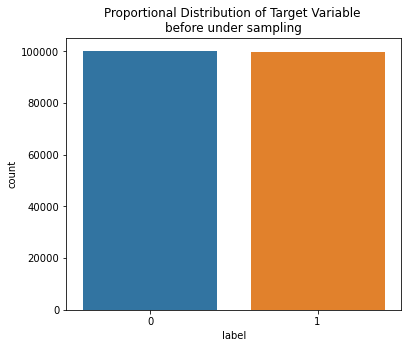

Initiating undersampling of data
 Real review count: 99823
 Fake review count: 100177
Require no under sampling 

Initiating data pre-processing
Data preprocessing completed



In [50]:
manipulatedData = dataManipulation(data)
preProcessedData = preProcessData(manipulatedData)


Random Forest Classifier

Split labeled data into train and test sets
Train a Random Forest Classifier on labeled data
Evaluate the classifier on the test set
Model Evaluation accuracy: 81.2625
Classification Report :
               precision    recall  f1-score   support

           0       0.83      0.79      0.81     20035
           1       0.80      0.83      0.82     19965

    accuracy                           0.81     40000
   macro avg       0.81      0.81      0.81     40000
weighted avg       0.81      0.81      0.81     40000



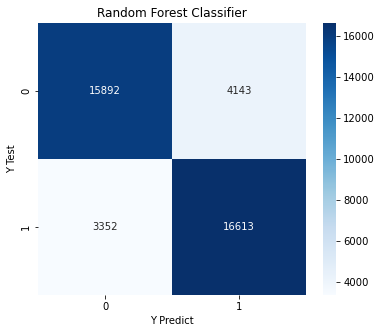

In [82]:
r_acc = rfModel(preProcessedData)


Naive Bayes Classifier

Split labeled data into train and test sets
Train Naive Bayes on labeled data
Evaluate the classifier on the test set
Model Evaluation accuracy: 82.965
Classification Report :
               precision    recall  f1-score   support

           0       0.81      0.86      0.83     20035
           1       0.85      0.80      0.82     19965

    accuracy                           0.83     40000
   macro avg       0.83      0.83      0.83     40000
weighted avg       0.83      0.83      0.83     40000



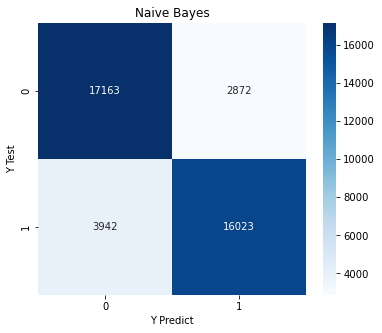

In [83]:
n_acc = nbModel(preProcessedData)


Convolution Neural Network

Spliting train data and test data
CNN Model building
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 165, 32)           4257440   
                                                                 
 dropout_8 (Dropout)         (None, 165, 32)           0         
                                                                 
 conv1d_8 (Conv1D)           (None, 161, 64)           10304     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)       

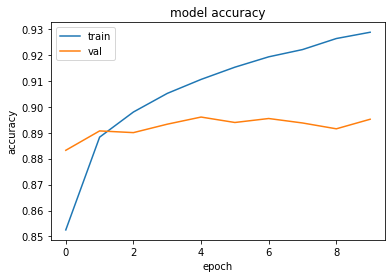

Model Evaluation accuracy: 95.085
Classification Report :
               precision    recall  f1-score   support

           0       0.95      0.96      0.95     20108
           1       0.95      0.95      0.95     19892

    accuracy                           0.95     40000
   macro avg       0.95      0.95      0.95     40000
weighted avg       0.95      0.95      0.95     40000



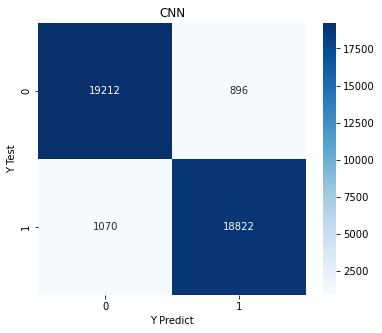

In [84]:
c_acc = cnn(preProcessedData)    


Long-Short Term Memory

Spliting train data and test data
LSTM Model building
Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 148, 32)           4257440   
                                                                 
 lstm_4 (LSTM)               (None, 100)               53200     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 20)                2020      
                                                                 
 dropout_11 (Dropout)        (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 21        
                                                 

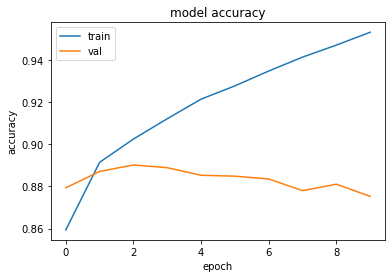

Model Evaluation accuracy: 96.99
Classification Report :
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     20108
           1       0.98      0.96      0.97     19892

    accuracy                           0.97     40000
   macro avg       0.97      0.97      0.97     40000
weighted avg       0.97      0.97      0.97     40000



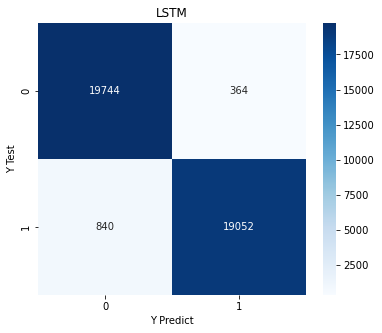

In [85]:
l_acc = lstm(preProcessedData)    


CNN-BiLSTM

Spliting train data and test data
CNN-BiLSTM Model building
Model: "CNN-BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 5000)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 5000, 300)         6000000   
                                                                 
 conv1d_6 (Conv1D)           (None, 4992, 32)          86432     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 312, 32)          0         
 1D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 312, 32)           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 306, 32)     

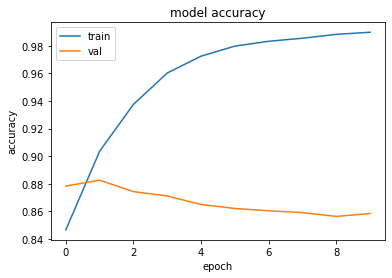

Model Evaluation accuracy: 99.7375
Classification Report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     20108
           1       1.00      1.00      1.00     19892

    accuracy                           1.00     40000
   macro avg       1.00      1.00      1.00     40000
weighted avg       1.00      1.00      1.00     40000



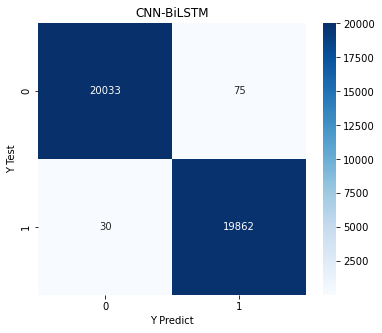

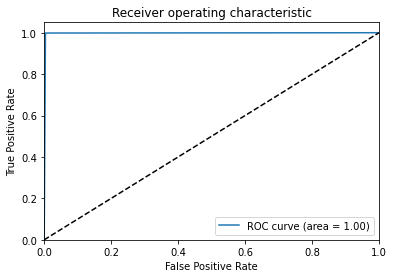

In [57]:
cbl_acc = cnn_bi_lstm(preProcessedData)

In [86]:
modelAccuracy(r_acc, n_acc, c_acc, l_acc, cbl_acc)




        Models        |    Accuracy(%)   
    Random Forest     |      81.2625
------------------------------------------
     Naive Bayes      |      82.965
------------------------------------------
         CNN          |      95.085
------------------------------------------
         LSTM         |      96.99
------------------------------------------
      CNN-BiLSTM      |      99.7375
